# Fragmentation Procedure

In this notebook, I'll do the entire fragmentation procedure. The goal will be to get a set of pure fragments for use in the paper. We'll focus on bringing down the purity value of all fragments to 0.02. Then, when we do the buffer region generation, we'll do it on a per fragment basis, and not per atom.

## Basic Setup

In [1]:
from CheSS import Matrices as M

class blockparam:
    def __init__(self, folder):
        self.density_file = folder+"/density_kernel_sparse.mtx"
        self.hamiltonian_file = folder+"/hamiltonian_sparse.mtx"
        self.overlap_file = folder+"/overlap_sparse.mtx"
        self.metadata_file = folder+"/sparsematrix_metadata.dat"
        
    def build_lookup(self):
        alookup = M.get_atomic_lookup(self.metadata_file)
        self.atom_to_basis = [[] for x in range(0, max(alookup)+1)]
        for basis, atom in enumerate(alookup):
            self.atom_to_basis[atom].append(basis)
    
    def read_matrices(self):
        from scipy.io import mmread
        from scipy.sparse.linalg import inv
        self.overlap = mmread(self.overlap_file)
        self.density = mmread(self.density_file)
        self.hamiltonian = mmread(self.hamiltonian_file)
        self.KS = 0.5*self.density.dot(self.overlap).todense()
        self.sinv = inv(self.overlap)
        self.sinvxh = self.sinv.dot(self.hamiltonian)
        self.sinvxh2 = self.sinvxh.dot(self.sinvxh)

In [3]:
data = blockparam("Matrices")
data.build_lookup()
data.read_matrices()
geom_file = "Matrices/1L2Y.yaml"

/usr/local/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [4]:
from BigDFT import Fragments as F
from yaml import load
with open(geom_file) as ifile:
    sys = load(ifile)
    positions = sys["Reading positions"].itervalues().next()
fdict = F.CreateFragDict(positions)

In [5]:
from numpy import zeros
electron_lookup = {'H' :1, 'He':2, 
                   'Li':1, 'Be':2, 'B' :3, 'C': 4, 'N':5, 'O':6, 'F' :7, 'Ne':8,
                   'Na':1, 'Mg':2, 'Al':3, 'Si':4, 'P':5, 'S':6, 'Cl':7}
natoms = len(positions["positions"])
charge = zeros((natoms))
for i, p in enumerate(positions["positions"]):
    name = p.keys()[1]
    charge[i] = electron_lookup[name]

## Purity Analysis

Next we'll do the analysis of the purity of each fragment.

In [6]:
def compute_purity(param, charge, frag):
    from numpy import zeros
    from numpy import trace
    from scipy.sparse import csr_matrix
    if (len(frag)) == 0:
        return 0
    indices = []
    cv = 0
    for atom in frag:
        indices += param.atom_to_basis[atom-1]
        cv += charge[atom-1]

    submat = param.KS[indices,:]
    submat = submat[:,indices]
    
    return -2*trace(submat.dot(submat) - submat)/cv

Here's some code to compute, categorize and plot the purity values.

In [7]:
def plot_purity(frag_dict):
    # First create a list for the purity value function
    frag_lists = {"Protein":[], "Water":[], "Ions":[]}
    for fname in frag_dict.keys():
        for fid in frag_dict[fname].keys():
            if "WAT" in fname:
                frag_lists["Water"].append(frag_dict[fname][fid])
            elif "SOD" in fname or "CLA" in fname or "Cl" in fname:
                frag_lists["Ions"].append(frag_dict[fname][fid])
            else:
                frag_lists["Protein"].append(frag_dict[fname][fid])
            
    # Compute
    purity_values = {"Protein":[], "Water":[], "Ions":[]}
    for category in frag_lists:
        for frag in frag_lists[category]:
            purity_values[category].append(compute_purity(data, charge, frag))
        
    from matplotlib import pyplot as plt
    import matplotlib.ticker as plticker
    fig, axs = plt.subplots(1, 3, figsize=(14,4), sharex=False, sharey=True,
                      gridspec_kw = {'width_ratios':[4, 3, 2
                                                    ]})
    for i, cat in enumerate(["Protein", "Water", "Ions"]):
        axs[i].plot(range(0, len(purity_values[cat])), purity_values[cat], 'x')
        axs[i].margins(x=0.1,y=0.1)
    loc = plticker.MultipleLocator(base=1.0)
    axs[2].xaxis.set_major_locator(loc)
    axs[0].set_ylabel("Purity Value", fontsize=12)
    axs[0].set_xlabel("Protein Residues", fontsize=12)
    axs[1].set_xlabel("Water Residues", fontsize=12)
    axs[2].set_xlabel("Ion Residues", fontsize=12)

Starting with the default fragmentation

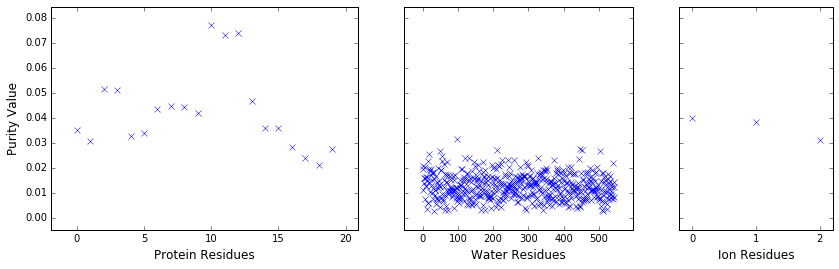

In [9]:
plot_purity(fdict)

## Cl Refragmentation
We'll now perform the refragmentation analysis. First, we will refragment the ions in solution (Na+Cl). For that purpose, we will merge the ion atoms with their three nearest neighbors.

In [10]:
def GetNearest(fragtuple, sysfile, threshold=None, number=None):
    import numpy as np
    sys = F.System(posinp_dict=sysfile)
    for f in sys.fragments:
        if f.id == F.SetFragId(*fragtuple):
            our_frag = f
            break
    distance_array =[F.distance(our_frag, f, cell=sysfile["cell"]) for f in sys.fragments]
    ipiv = np.argsort(distance_array)
    if number:
        shell = ipiv[:number]
    else:
        shell = np.where(np.array(distance_array) < threshold)[0]
    shellid = [sys.fragments[s].id for s in shell]
    return shellid

In [11]:
clcluster568 = GetNearest(("CLA",568), positions, number=3+1)
for near in clcluster568:
    fname, fid = near.split(":")
    print(near, compute_purity(data, charge, fdict[fname][int(fid)]))
print()

clcluster567 = GetNearest(("CLA",567), positions, number=3+1)
for near in clcluster567:
    fname, fid = near.split(":")
    print(near, compute_purity(data, charge, fdict[fname][int(fid)]))
print()

nacluster = GetNearest(("SOD",566), positions, number=3+1)
for near in nacluster:
    fname, fid = near.split(":")
    print(near, compute_purity(data, charge, fdict[fname][int(fid)]))
print()

('CLA:568', 0.040056826588905539)
('WAT:406', 0.013247900028964865)
('WAT:473', 0.027309054871141575)
('WAT:445', 0.013556558012085426)
()
('CLA:567', 0.038169349592373357)
('WAT:562', 0.021859518913813714)
('WAT:496', 0.014627662583902454)
('WAT:389', 0.0047951201723527709)
()
('SOD:566', 0.031301211576577316)
('WAT:407', 0.012050354731200669)
('WAT:124', 0.0081064030106595963)
('WAT:379', 0.0093150269494872012)
()


Now update the fragment dictioanry with these new merged fragments.

In [12]:
from copy import deepcopy
re_dict = deepcopy(fdict)

re_dict["Cl Cluster"] = {}
re_dict["Na Cluster"] = {}

re_dict["Cl Cluster"][567] = []
for f in clcluster567:
    fname, fid = f.split(":")
    re_dict["Cl Cluster"][567] += fdict[fname][int(fid)]
    del re_dict[fname][int(fid)]
    
re_dict["Cl Cluster"][568] = []
for f in clcluster568:
    fname, fid = f.split(":")
    re_dict["Cl Cluster"][568] += fdict[fname][int(fid)]
    del re_dict[fname][int(fid)]
   
re_dict["Na Cluster"][566] = []
for f in nacluster:
    fname, fid = f.split(":")
    re_dict["Na Cluster"][566] += fdict[fname][int(fid)]
    del re_dict[fname][int(fid)]

We can look at the purity values after the chlorine clusters have been generated.

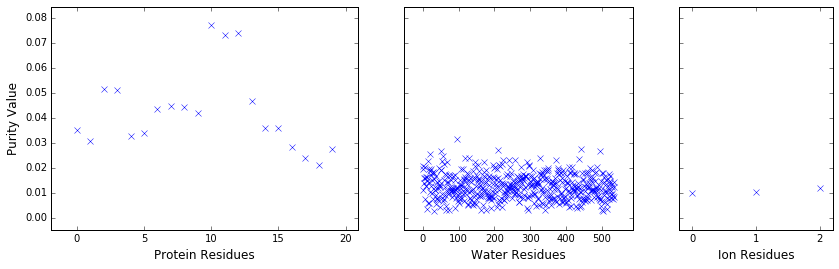

In [13]:
plot_purity(re_dict)

## Protein Refragmentation
Now we need to refragment the protein residues. First, let's extract the protein residues.

In [14]:
pro_dict = {}
for fname in re_dict.keys():
    if not "CLA" in fname and "Cl" not in fname and "SOD" not in fname and "WAT" not in fname:
        if not fname in pro_dict:
            pro_dict[fname] = {} 
        for fid in re_dict[fname].keys():
            pro_dict[fname][int(fid)] = re_dict[fname][fid]


Now the plot with labels function.

In [19]:
def plot_protein(dict_list, title, file_name=None):
    from matplotlib import pyplot as plt
    from matplotlib import rcParams
    import numpy.ma as ma
    
    fig, ax = plt.subplots(len(dict_list),1,figsize=(8,8))
    
    if len(dict_list) == 1:
        ax = [ax]
    
    for axi, ldict in enumerate(dict_list):
        labels = []
        purity = []
        odd = []
        for i in range(0, 21):
            labels.append("")
            purity.append(-1)
            odd.append("")
        for fname in ldict.keys():
            for fid in ldict[fname].keys():
                labels[int(fid)-1] = fname
                purity[int(fid)-1] = compute_purity(data,charge,ldict[fname][fid])
                cv = 0
                for atom in ldict[fname][fid]:
                    cv += charge[atom-1]
                if int(cv) % 2 == 0:
                    odd[int(fid)-1] = False
                else:
                    odd[int(fid)-1] = True

        labels[-1] = "Full Protein"
        full_atom = []
        for fname in ldict:
            for fid in ldict[fname]:
                full_atom.extend(ldict[fname][fid])
        purity[-1] = compute_purity(data, charge, full_atom)

        ax[axi].plot(ma.array(purity, mask=odd), 'x', color="r", markersize=10, label="Even Electrons")
        ax[axi].plot(ma.array(purity, mask=[not x for x in odd]), '+', color="g", markersize=10,
                label="Odd Electrons")

        ax[axi].set_ylabel("Purity Value", fontsize=12)
        ax[axi].set_xlim(-1,21)
        ax[axi].set_ylim(0, 0.1)

        ax[axi].axhline(0.025, color="black", linestyle="--", label="Purity 0.025")

        ax[axi].tick_params(labelsize=12)
        ax[axi].set_xticks(range(len(labels)))
        ax[axi].set_xticklabels(labels, rotation=90)
        ax[axi].set_title(title[axi])
    
    ax[0].legend(loc="best")
    ax[-1].set_xlabel("Protein Residues", fontsize=12)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if file_name:
        plt.savefig(file_name)

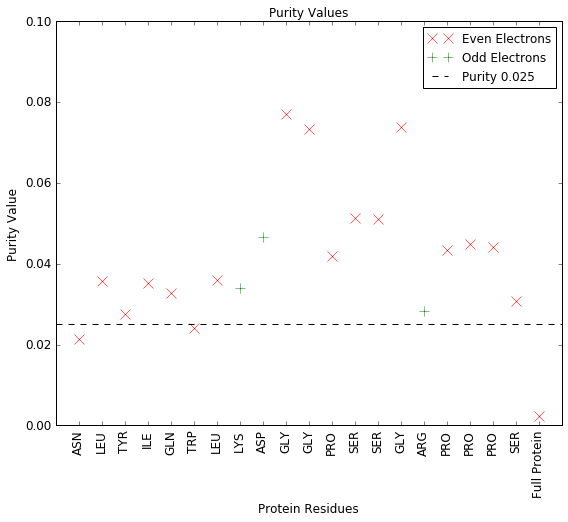

In [20]:
plot_protein([pro_dict],["Purity Values"])

Merge together the two GLY

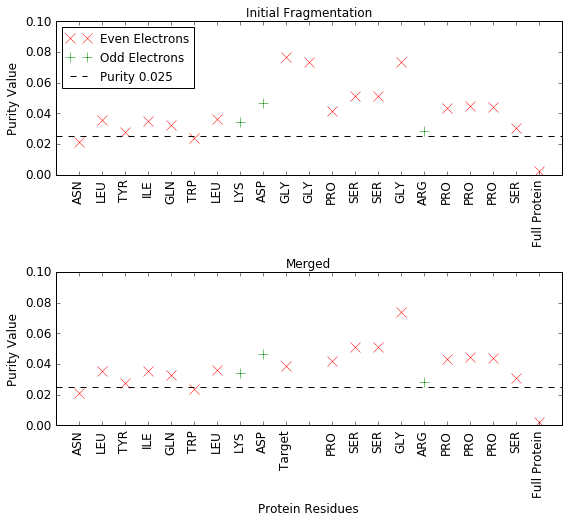

In [37]:
mdict = deepcopy(pro_dict)
mdict["Target"] = {}
mdict["Target"][10] = mdict["GLY"][10]
mdict["Target"][10] += mdict["GLY"][11]
del mdict["GLY"][10]
del mdict["GLY"][11]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

The second GLY with the neighboring SER

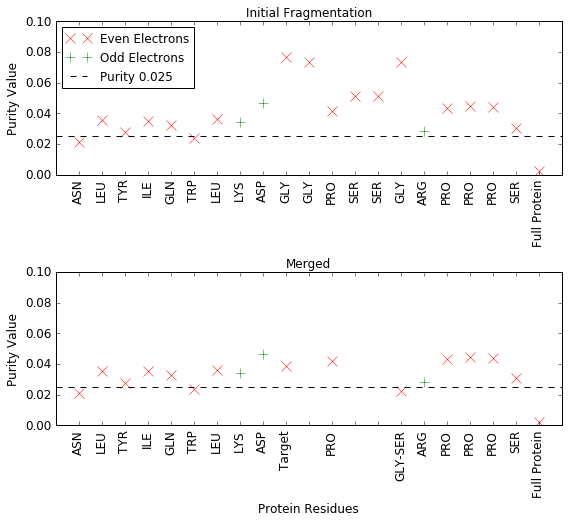

In [38]:
mdict["GLY-SER"] = {}
mdict["GLY-SER"][15] = mdict["GLY"][15]
mdict["GLY-SER"][15] += mdict["SER"][14]
mdict["GLY-SER"][15] += mdict["SER"][13]
del mdict["SER"][14]
del mdict["SER"][13]
del mdict["GLY"][15]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

Merge the entire GLY-PRO-GLY portion.

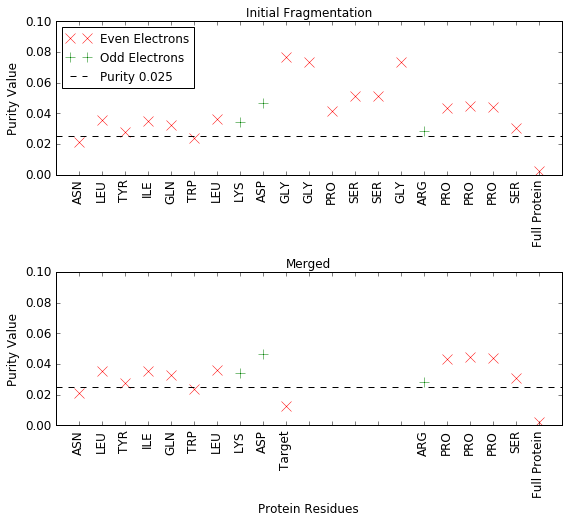

In [39]:
mdict["Target"][10] += mdict["PRO"][12]
mdict["Target"][10] += mdict["GLY-SER"][15]
del mdict["PRO"][12]
del mdict["GLY-SER"][15]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

The three PRO

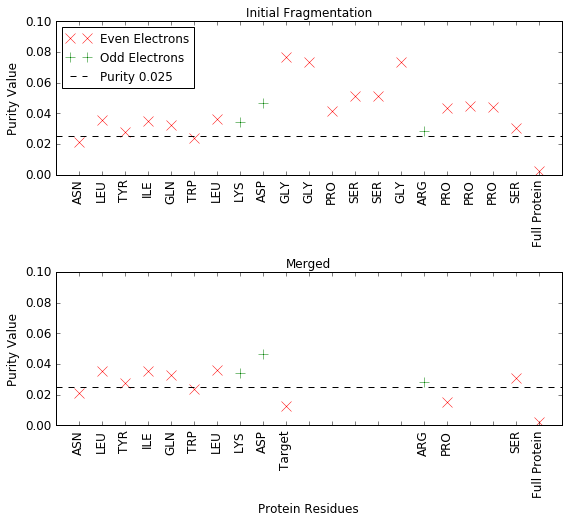

In [40]:
mdict["PRO"][17] += mdict["PRO"][18]
mdict["PRO"][17] += mdict["PRO"][19]
del mdict["PRO"][18]
del mdict["PRO"][19]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

LYS and ASP

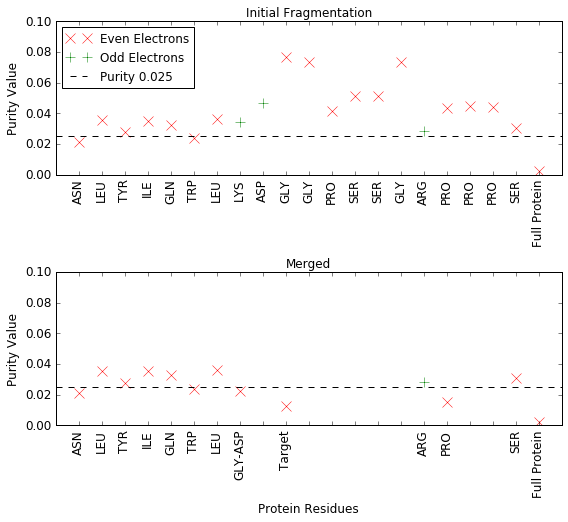

In [41]:
mdict["GLY-ASP"] = {}
mdict["GLY-ASP"][8] = mdict["LYS"][8]
mdict["GLY-ASP"][8] += mdict["ASP"][9]
del mdict["ASP"][9]
del mdict["LYS"][8]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

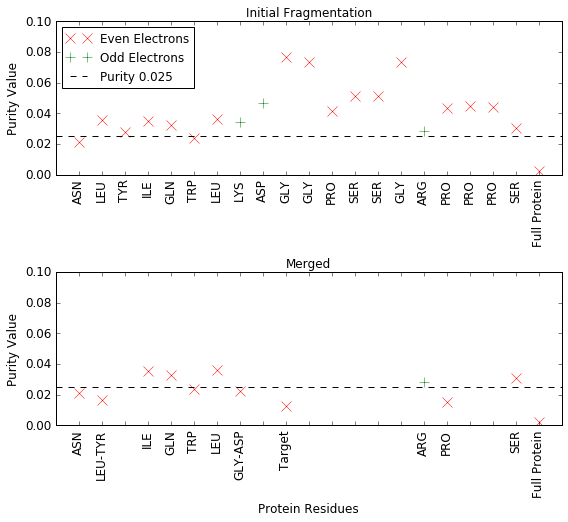

In [42]:
mdict["LEU-TYR"] = {}
mdict["LEU-TYR"][2] = mdict["LEU"][2]
mdict["LEU-TYR"][2] += mdict["TYR"][3]
del mdict["LEU"][2]
del mdict["TYR"][3]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

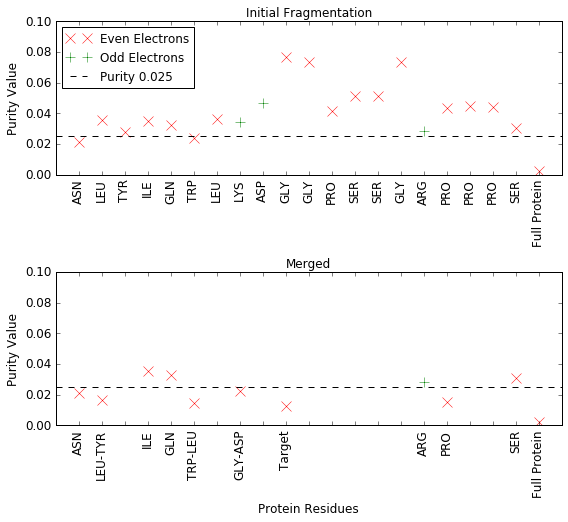

In [43]:
mdict["TRP-LEU"] = {}
mdict["TRP-LEU"][6] = mdict["TRP"][6]
mdict["TRP-LEU"][6] += mdict["LEU"][7]
del mdict["TRP"][6]
del mdict["LEU"][7]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"])

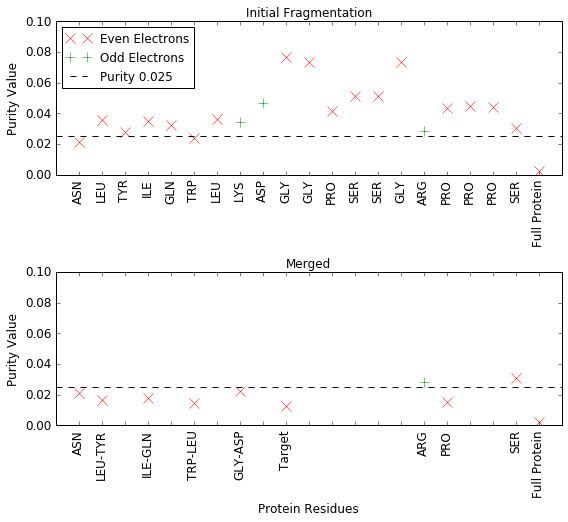

In [44]:
mdict["ILE-GLN"] = {}
mdict["ILE-GLN"][4] = mdict["ILE"][4]
mdict["ILE-GLN"][4] += mdict["GLN"][5]
del mdict["ILE"][4]
del mdict["GLN"][5]
plot_protein([pro_dict, mdict], ["Initial Fragmentation", "Merged"], "Pictures/merged.eps")

And finally lets put this fragmentation information back into the full dictionary list.

In [29]:
new_frags = deepcopy(re_dict)

for fname in pro_dict:
    for fid in pro_dict[fname]:
        del new_frags[fname][fid]
new_frags = {k: v for k, v in new_frags.items() if any(v)}

for fname in mdict:
    if not fname in new_frags:
        new_frags[fname] = {}
    for fid in mdict[fname]:
        new_frags[fname][fid] = mdict[fname][fid]
print(new_frags.keys())

['TYR', 'ILE', 'SER', 'GLN', 'LYS', 'PRO', 'TRP-LEU', 'ILE-GLN', 'TRP', 'ASN', 'GLY', 'Na Cluster', 'LEU', 'ARG', 'LEU-TYR', 'ASP', 'WAT', 'GLY-SER', 'Cl Cluster', 'GLY-ASP', 'Target']


We should also write a YAML file and use it to recompute all the Multipoles associated with this new fragmentation.

In [30]:
protein_atoms = []
for fname in pro_dict:
    for fid in pro_dict[fname]:
        protein_atoms.extend(pro_dict[fname][fid])
        
with open("new_frag_list.yaml", "w") as ofile:
    for fname in new_frags:
        for fid in new_frags[fname]:
            ofile.write("- ")
            ofile.write(str(new_frags[fname][fid]))
            ofile.write("\n")
    ofile.write("- ")
    ofile.write(str(protein_atoms))
    ofile.write("\n")

## Spillage Analysis
The next step is the spillage analysis. What we want to do now is to compute spillage values from fragment to fragment, not just fragment to atoms.

In [31]:
class QMMM:
    def __init__(self, frag_dict, target, target_name):
        from copy import deepcopy
        self.fdict = deepcopy(frag_dict)
        self.target = target
        self.target_name = target_name
        
        self.compute_frag_list()
        
    def compute_frag_list(self):
        self.frag_list = []
        for fname in self.fdict.keys():
            for fid in self.fdict[fname].keys():
                self.frag_list.append(self.fdict[fname][fid])
                
    def compute_spillage(self, param):
        from numpy import trace
        
        self.val_list = []
        if (len(self.target)) == 0:
            return 0
        indices_f = []
    
        for atom in self.target:
            indices_f += param.atom_to_basis[atom-1]
            
        denom = param.sinvxh[:,indices_f]
        denom = denom[indices_f,:]
        denom = denom.todense()
        denom = denom.dot(denom)
        self.denom_t = trace(denom)

        H2T = param.sinvxh2[:,indices_f]
        H2T = H2T[indices_f,:]
        self.left_t = trace(H2T.todense())

        for frag_G in self.frag_list:
            indices_g = []
            for atom in frag_G:
                indices_g += param.atom_to_basis[atom-1]

            TFH = param.sinvxh[indices_f,:]
            TFHTG = TFH[:,indices_g].todense()

            TGH = param.sinvxh[indices_g,:]
            TGHTF = TGH[:,indices_f].todense()

            right_mat = (TFHTG.dot(TGHTF))
            val = trace(right_mat)
            self.val_list.append(val)
        self.spillage_values = self.val_list/self.denom_t
        
    def plot(self, ax, marker):
        ax.plot(sorted(self.spillage_values, reverse=True), marker=marker, 
                markersize=10, label=self.target_name)
        
    def compute_buffer(self, threshold):
        buffer_region_frags = []
        for j in range(0, len(self.spillage_values)):
            if abs (self.spillage_values[j]) > threshold:
                buffer_region_frags.append(j)
        buffer_region_atoms = []    
        for frag in buffer_region_frags:
            for atom in self.frag_list[frag]:
                buffer_region_atoms.append(atom)
        return buffer_region_frags, buffer_region_atoms

Also, the spillage values from the full protein to the environment

In [32]:
prot_env_dict = deepcopy(re_dict)

prot_env_dict["Mini-Protein"] = {}
prot_env_dict["Mini-Protein"][1] = []
for fname in pro_dict:
    for fid in pro_dict[fname]:
        prot_env_dict["Mini-Protein"][1] += re_dict[fname][fid]
        del prot_env_dict[fname][fid]
prot_env_dict = {k: v for k, v in prot_env_dict.items() if any(v)}

In [33]:
QMMM_dict = {}
temp = QMMM(new_frags, new_frags["Target"][10], "Target")
QMMM_dict["Target"] = deepcopy(temp)
QMMM_dict["Target"].compute_spillage(data)

temp = QMMM(new_frags, new_frags["Cl Cluster"][567], "Cl Cluster 567")
QMMM_dict["Cl Cluster 567"] = deepcopy(temp)
QMMM_dict["Cl Cluster 567"].compute_spillage(data)

temp = QMMM(new_frags, new_frags["Cl Cluster"][568], "Cl Cluster 568")
QMMM_dict["Cl Cluster 568"] = deepcopy(temp)
QMMM_dict["Cl Cluster 568"].compute_spillage(data)

temp = QMMM(new_frags, new_frags["Na Cluster"][566], "Na Cluster")
QMMM_dict["Na Cluster"] = deepcopy(temp)
QMMM_dict["Na Cluster"].compute_spillage(data)

temp = QMMM(prot_env_dict, prot_env_dict["Mini-Protein"][1], "Mini-Protein")
QMMM_dict["Mini-Protein"] = deepcopy(temp)
QMMM_dict["Mini-Protein"].compute_spillage(data)

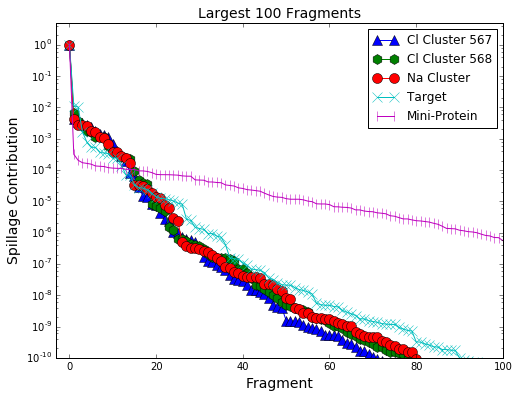

In [46]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.set_yscale("log")
ax.set_xlabel("Fragment",fontsize=14)
ax.set_ylabel("Spillage Contribution",fontsize=14)
ax.set_title("Largest 100 Fragments", fontsize=14)
ax.set_xlim(-3,100)
ax.set_ylim(1e-10,5)

system_labels=["Cl Cluster 567", "Cl Cluster 568", "Na Cluster", "Target", "Mini-Protein"]

markers = ['^', 'h', 'o', 'x', '|']
for d, m in zip(system_labels, markers):
    QMMM_dict[d].plot(ax, m)

plt.legend(loc="best")
fig.savefig("Pictures/Spillage.eps")

How large of a buffer would each of these targets need to hit ten to the minus four?

In [47]:
import sys
sys.stdout.write("Threshold ")
for header in sorted(QMMM_dict.keys()):
    sys.stdout.write(" & "+header)
sys.stdout.write("\\\\\n")
print("\midrule")
for thresh in [2, 3, 4, 5, 6, 7, 8]:
    threshold = 10**(-1*thresh)
    sys.stdout.write("$1.0 \\times 10^{-"+str(thresh)+"}$")
    
    for t in system_labels:
        target_size = len(QMMM_dict[t].target)
        region_frag, region_atom = QMMM_dict[t].compute_buffer(threshold)
        sys.stdout.write(" & "+str(len(region_atom)-target_size))
    sys.stdout.write("\\\\")
    print

Threshold  & Cl Cluster 567 & Cl Cluster 568 & Mini-Protein & Na Cluster & Target\\
\midrule
$1.0 \times 10^{-2}$ & 0 & 0 & 0 & 58 & 0\\
$1.0 \times 10^{-3}$ & 27 & 24 & 24 & 61 & 0\\
$1.0 \times 10^{-4}$ & 39 & 42 & 42 & 128 & 45\\
$1.0 \times 10^{-5}$ & 54 & 54 & 63 & 164 & 165\\
$1.0 \times 10^{-6}$ & 72 & 72 & 75 & 185 & 279\\
$1.0 \times 10^{-7}$ & 123 & 123 & 105 & 251 & 369\\
$1.0 \times 10^{-8}$ & 162 & 157 & 160 & 318 & 456\\


## Preparation of QM/MM Regions
Now we will prepare the QM/MM input files for each of the target/buffer combinations. First we load in the input minimal file from the full run. Second, we read the file that has the multipole values for each of the fragments.

In [49]:
from yaml import load
with open("mindna.yaml") as ifile:
    min_param = load(ifile)
with open("Matrices/log.yaml") as ifile:
    multi_val = load(ifile)

Set up the basic parameters based on the minimal parameters

In [50]:
output_template = deepcopy(min_param)
output_template["posinp"] = deepcopy(positions)

From the multipole value file we need to extract the multipoles and positions

In [51]:
from copy import deepcopy
m_values = deepcopy(multi_val["Multipole coefficients"])
p_values = deepcopy(positions)

output_template["posinp"] = deepcopy(p_values)
output_template["dft"]["external_potential"] = m_values

In [52]:
def fix_charge(atom_list):
    cv = 0
    for atom in atom_list:
        cv += charge[atom-1]
    if int(cv) % 8 == 0:
        return 0
    elif int(cv) % 8 > 4:
        return -1.0
    else:
        return 1.0

In [53]:
def fix_charge2(atom_list):
    cv = 0
    for atom in atom_list:
        nzion = multi_val["Multipole coefficients"]["values"][atom-1]["nzion"]
        q0 = multi_val["Multipole coefficients"]["values"][atom-1]["q0"][0]
        cv += nzion + q0
    return cv

Now for each threshold and system we have to generate the required buffer positions, and the inverse of the multipole coefficients.

In [54]:
from yaml import dump
for thresh in [2, 3, 4, 5, 6, 7, 8]:
    threshold = 10**(-1*thresh)
    for t in QMMM_dict:
        out_name = t+"-"+str(thresh)+".yaml"
        frag_name = t+"-"+str(thresh)+"-frag.yaml"
        region_frag, region_atom = QMMM_dict[t].compute_buffer(threshold)
        new_pos = []
        for atom in region_atom:
            new_pos.append(positions["positions"][atom-1])
        new_m = []
        for i in range(0, len(m_values["values"])):
            if i+1 not in region_atom:
                new_m.append(m_values["values"][i])
        out_dict = deepcopy(output_template)
        out_dict["dft"]["external_potential"]["values"] = new_m
        out_dict["posinp"]["positions"] = new_pos
        c1 = fix_charge(region_atom)
        c2 = fix_charge2(region_atom)
        out_dict["dft"]["qcharge"] = round(c2)
        del out_dict["dft"]["external_potential"]
        
        print(out_name)
        with open("QMMMInput/"+out_name, "w") as ifile:
            dump(out_dict, ifile)
            
        target_list = []
        for i, atom in enumerate(region_atom):
            if atom in QMMM_dict[t].target:
                target_list.append(i+1)
            
        with open("QMMMInput/"+frag_name, "w") as ofile:
            dump([target_list], ofile)

Cl Cluster 567-2.yaml
Na Cluster-2.yaml
Mini-Protein-2.yaml
Target-2.yaml
Cl Cluster 568-2.yaml
Cl Cluster 567-3.yaml
Na Cluster-3.yaml
Mini-Protein-3.yaml
Target-3.yaml
Cl Cluster 568-3.yaml
Cl Cluster 567-4.yaml
Na Cluster-4.yaml
Mini-Protein-4.yaml
Target-4.yaml
Cl Cluster 568-4.yaml
Cl Cluster 567-5.yaml
Na Cluster-5.yaml
Mini-Protein-5.yaml
Target-5.yaml
Cl Cluster 568-5.yaml
Cl Cluster 567-6.yaml
Na Cluster-6.yaml
Mini-Protein-6.yaml
Target-6.yaml
Cl Cluster 568-6.yaml
Cl Cluster 567-7.yaml
Na Cluster-7.yaml
Mini-Protein-7.yaml
Target-7.yaml
Cl Cluster 568-7.yaml
Cl Cluster 567-8.yaml
Na Cluster-8.yaml
Mini-Protein-8.yaml
Target-8.yaml
Cl Cluster 568-8.yaml
